## Using MNIST Dataset

In [1]:
import warnings 
warnings.simplefilter('ignore')
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', transpose_data=True, data_home ='files')
mnist

/Users/nigelnicholas/Library/Python/3.6/lib/python/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/nigelnicholas/Library/Python/3.6/lib/python/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist["data"], mnist["target"] # X is data and y is label
print("shape of X: {}, shape of y: {}".format(X.shape,y.shape))

shape of X: (70000, 784), shape of y: (70000,)


<style>
   .cursive{
      font-family: cursive;
    }
</style>
X is the representation of data collected, and y is the label.  
X represents 70000 sample, consisting of 28x28 pixel.  


In [4]:
import matplotlib
import matplotlib.pyplot as plt

example = X[36000]
reshaped = example.reshape(28,28)
plt.imshow(reshaped, cmap =matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print("Label: {}".format(y[36000]))

<Figure size 640x480 with 1 Axes>

Label: 5.0


plt.imshow() shows the five-like image above. And the label shows that it is indeed 5.

## Data Splitting  

Assume we're going to have 60000 as training and the remaining 10000 as test. 

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Code above is if you want to use sets sequentially. (First 60000 as training and the remaining as test).

However sometimes it's also important to shuffle order of training instances, sometimes the order of instances may influence the value being close to each other, hence when training doesn't capture the whole data.

To shuffle:

In [6]:
import numpy as np 

shuffle_index = np.random.permutation(60000)  # where the random happens
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

Classifying instances into 1 or 0. Now we simply find whether a digit is 5 or not. Only distinguish between 2 classes.

In [7]:
y_train_5 = (y_train == 5)  
y_test_5 = (y_test == 5) # Creating array made of True and False(of whether that instance is labelled as 5)

Using __SGD Classifier__ (Stochastic Gradient Descent) is advantageous in this one. SGD deals with training instances independently, one at a time. SGD relies on randomness during training.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd=SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

After fitting data into model we can now do prediction by simply:

```python

sgd.predict([1,3,5,...]) 
```

## Measuring Performance

### Cross-Validation
Implementation:


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#method: split training set into 3 subsets. For each of the subsets, fit into the clone of the sgd classifier, do predictions 
#and calculate the accuracy of the classifier.

skfolds=StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_classifier=clone(sgd)  # create clone so that it doesn't affect the original sgd classifier
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_classifier.fit(X_train_folds, y_train_folds)
    y_pred = clone_classifier.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9622
0.9687
0.96415


StratifiedKFold class performs stratified sampling (<https://en.wikipedia.org/wiki/Stratified_sampling>). In summary, stratified sampling is sampling for a population that is divided into sub-populations. However, the division of subpopulation is such that each subpopulation is a homogenous group, that they are mutually exclusive and exhaustive. Stratified sampling produce folds that contain a representative ratio of each class.

Alternative to implementing our own, we can simply use ``` cross_val_score()```

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9622 , 0.9687 , 0.96415])

the k-fold cross validation means splitting training set into k-folds then making predictions and evaluating them on each fold using a model.  

However, accuracy is not the best measure of score. 

In [11]:
sum(y_train_5)

5421

Code above shows that only 5421 digits are labelled 5. Therefore even if your classifier classify all as non-5, the accuracy of the classifier is still (60000-5421)/60000. Accuracy therefore is not a good measure for skewed datasets.

With that in mind it's time we look into other performance measures.

## Confusion Matrix

it's a n by n matrix ( where n is the number of classes ). Each row in confusion matrix represents actual class and each column represents predicted class. So row 5 column 3 shows the number of 5 misclassified as a 3.

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred =cross_val_predict(sgd, X_train, y_train_5, cv=3) # cross_val_predict does a kfold cross validation
matrix = confusion_matrix(y_train_5, y_train_pred)
matrix


array([[54049,   530],
       [ 1569,  3852]])

From array above we an see that n x n table. First row shows the non-5 images and means that 54025 pictures are classified correctly meanwhile.

Let's assume we have a _positive_ class and _negative_ class. Take _negative_ as the non-5.

From the array above we can see that, 54025 are correctly classified and 554 class non-5 are misclassified as class 5. The classifier results to __54025 True Negative__ and __554 False Positive__. Continuing this logic: 1568 __False Negatives__ and 3853 __True Positives__.

If a classifier is perfect ( such that it predicts all exactly like the supposed class. It should contain only True Positives nad True Negatives.

## Some Possible Metrics 

[precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)  
[recall score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

\begin{equation*}
precision = \frac{TP}{(TP+FP)} \\
recall = \frac{TP}{TP+FN}\\
\end{equation*}

In [13]:
from sklearn.metrics import precision_score, recall_score

print('precision = {}'.format(precision_score(y_train_5, y_train_pred)))
print('recall = {}'.format(recall_score(y_train_5, y_train_pred)))

precision = 0.8790506617982656
recall = 0.7105700055340343


Combining the essence of precision and recall we get:

\begin{equation*}
F_1 = 2 \times \frac{precision \times recall}{precision + recall}
\end{equation*}

F1 score will favor classifiers that give similar precision and recall. Sometimes taking precision and recall on their own is also a good metric.  

Example where F1 score wouldnt be necessary is video filter. Classifier determining whether video is safe for kids or not. You prefer safety over good --> low recall and high precision.
High precision means: you need less false positives ( you want your positives to be mostly correct, reduce amount of positives)  

High reall means that you need less false negatives ( you should have classified more as a positive).

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7858818728960522

However, often times, precision and recall is usually a trade-off. (Increasing precision reduces recall).

<h2 style="font-family:cursive"> Precision/Recall Tradeoff </h2>

<img src="./img/002_1.jpg" width="500px" length="400px"> </img>


Asusming in the figure above that downward arrows are thresholds. 

If the arrow is in the middle we can see that there are 4 True Positives and 1 False Positive while having 2 false negatives. So Precision is 4/5 = 80% while recall is 4/6 = 67%.  

Say we want to increase the threshold to the right, which will give us 100% accuracy. However it decreases the recall to 3/6 = 50%.

Decreasing threshold will have reverse effect.

In [15]:
y_scores = sgd.decision_function(X_train)
threshold = 20000 #set threshold
y_dig_pred = (y_scores>threshold)
sum(y_dig_pred)

2997

The code section above tries to evaluate and use threshold to control how many should be considered positive. Increasing threshold reduces recall but increases precision.

In [16]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method='decision_function')
precisions , recalls, thresholds =precision_recall_curve(y_train_5,y_scores)

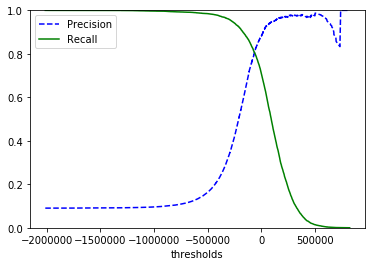

In [17]:
import matplotlib.pyplot as plt

def plotgraph(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel("thresholds")
    plt.legend()
    plt.ylim([0,1])

plotgraph(precisions, recalls,thresholds)
plt.show()

You want to find a threshold that gives reasonable precision and recall depending on the use of classifier.  
Let's take threshold of 70000.

In [18]:
y_train_pred_90 = (y_scores >70000)
# checking precision and recall
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9373050530255771
0.5543257701531082


<h2 style="font-family: cursive">ROC Curve</h2>


[ROC Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)  
_Receiver Operating Characteristics_. It plots _true positive rate_(recall) against _false positive rate_.  
__False Positive Rate__: Ratio of negative instances that are incorrectly classified as positive which can also be written as 1-_True Negative Rate_  
__True Negative Rate__: Ratio of negative instances that are correctly classified as negative. Also called _specificity_  
Therefore:
\begin{equation*}
ROC = \frac {recall}{1-specificity}
\end{equation*}


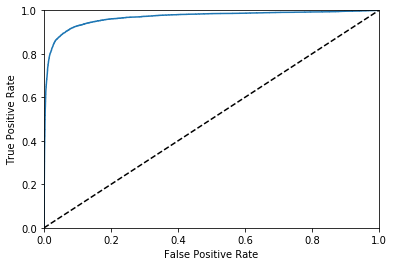

In [19]:
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc(fpr,tpr,label=None):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc(fpr,tpr)
plt.show()

To compare classifiers, we find the area under the curve. The perfect one should have 1.0 whereas randome ones have around 0.5. 

In [20]:
from sklearn.metrics import roc_auc_score # auc = area under the curve
roc_auc_score(y_train_5, y_scores)

0.9676074065338337

Trying out another type of classifier. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [21]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probs_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_probs_forest

array([[1. , 0. ],
       [0.8, 0.2],
       [0.8, 0.2],
       ...,
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ]])

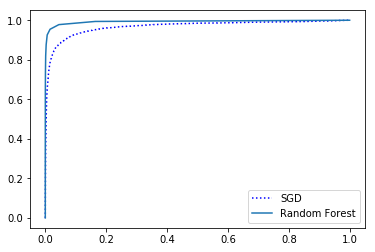

0.9932851591112516

In [22]:
y_scores_forest =y_probs_forest[:,1]
fpr_f, tpr_f, threshold_f = roc_curve(y_train_5, y_scores_forest)
# plotting to compare between sgd and random forest

def plot_forest():
    plt.plot(fpr,tpr,'b:',label='SGD')
    plt.plot(fpr_f, tpr_f, label='Random Forest')
    plt.legend(loc='bottom right')
    plt.show()

plot_forest()

forest_auc_score = roc_auc_score(y_train_5, y_scores_forest)
forest_auc_score

The way y_probs_forest is structured is that it has 2 probabilities. left one means probability for negative and right is the probability for positive class. Take the positive one because higher probability gives them more tendency to be in the positive class.

If you want to do classification from above, check the probability on the right. if >=0.5, categorize as + (True) else -(False). Then we can use it for precision and recall score check.



<h2 style='font-family:cursive'>Multiclass Classification</h2>

Ability for classifier to distinguish more than 2 classes.  

Some classifiers can handle multiple classes, however some can only do specifically on binary classes. But using binary, we can also do multiple classes by doing combination. There would be 2 strategies that can work. We will try the case of classifying 10 digits of numbers.  

__OvA__: _One Versus All_. We will create 10 binary classifiers for each digit. So to classify an image, get decision score from each of the 10 binary classifiers, then select which classifier gives the highest score. Each binary classifier mean that you will only take the positive one and compare that score.

__OvO__: _One Versus One_. For N classes, the classifiers to be created is:
\begin{equation*}
n = {N \choose 2}
\end{equation*}  
In the example of digits, with 10 classes we need to create 45 classes. During testing, it would usually be tedious to pass the image to all 45 classifiers before knowing whcih class it belongs to. One advantage would be that the training set only need to be passed to the specific classifier. For example: an image labelled as 3 should be passed to only classifiers that is comparing the classifier of 3 and some other (ex. 1&3, 2&3 ,..).  

OvO will be necessary for certain algorithms that doesn't scale well with huge size of training set.  


In [23]:
sgd.fit(X_train,y_train) # now only y_train not y_train_5 because we want to do 10 classes instead of 2.

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
predictions = sgd.predict(X_train)
predictions # contain 60000 results

array([6., 3., 0., ..., 6., 8., 3.])

In [25]:
sample = 2001 # can adjust the sample
score = sgd.decision_function(X_train[sample].reshape(1,-1))
print(score)

[[  733712.76112508 -1138955.66499608  -766241.36324891  -530402.39149608
   -480306.33508923  -358698.01405086  -890391.31123019  -436346.38103806
   -246765.70319426  -274910.11323699]]


In [26]:
# to get which class it belongs to 
classes=sgd.classes_
classes[np.argmax(score)]

0.0

_np.argmax()_ gives the index of the largest score in the array. _classes_ attribute is ordered by value. The index of each class matches the class itself. However we can also force the classifier to be either OvO or OvA.
[One Vs One Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

In [27]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [28]:
ovo_clf.predict(X_train[sample].reshape(1,-1)) # can change sample ( or to a range of instances)
est_num = len(ovo_clf.estimators_)
print("there are {} estimators".format(est_num))

there are 45 estimators


Using Random Forest Classifier

In [29]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

We can immediately predict with

In [30]:
forest_clf.predict(X_train[sample].reshape(1,-1))

array([0.])

In [31]:
forest_clf.predict_proba(X_test[1234].reshape(1,-1))
cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

array([0.874975  , 0.85154258, 0.84507676])

We can scale the inputs first using [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.91071786, 0.91074554, 0.90908636])

<h2 style='font-family:cursive'>Error Analysis</h2>

To improve model, we do error analysis to see which errors it often makes.  
We will look into confusion matrix.

In [33]:
predictions=cross_val_predict(sgd, X_train_scaled,y_train,cv=3)
predictions

array([6., 3., 4., ..., 6., 5., 9.])

In [34]:
conf_matrix=confusion_matrix(y_train,predictions)
conf_matrix

array([[5735,    3,   20,    9,   12,   46,   47,    7,   39,    5],
       [   2, 6447,   46,   28,    6,   45,    5,   11,  142,   10],
       [  56,   36, 5331,   97,   84,   26,   85,   54,  170,   19],
       [  41,   40,  148, 5361,    1,  218,   32,   60,  142,   88],
       [  19,   27,   31,    8, 5382,   11,   47,   25,   84,  208],
       [  73,   47,   38,  192,   68, 4598,   99,   24,  178,  104],
       [  33,   26,   48,    2,   39,   89, 5623,    5,   53,    0],
       [  27,   18,   67,   37,   61,   10,    6, 5799,   15,  225],
       [  48,  135,   73,  154,   17,  150,   47,   27, 5069,  131],
       [  42,   36,   27,   88,  167,   34,    3,  207,   79, 5266]])

Can do image representation of confusion matrix using [matshow()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.matshow.html)

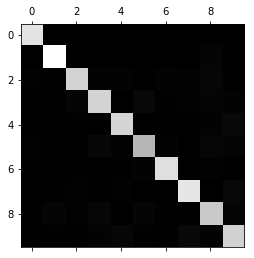

In [35]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

The important point is that the diagonal are all in white which means that the image is classified correctly. If image is darker, it means that there are fewer images that belong to that class or that the classifier misclassify it (bad at classifying that number) or possibly both.  

First error check is dividing each value in confusion matrix by total number of images in actual class (each row). We get the error rates. 

In [36]:
row_sum=conf_matrix.sum(axis=1,keepdims=True)
print(row_sum)
normalized_conf_matrix = conf_matrix/row_sum
print(normalized_conf_matrix)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
[[9.68259328e-01 5.06500084e-04 3.37666723e-03 1.51950025e-03
  2.02600034e-03 7.76633463e-03 7.93516799e-03 1.18183353e-03
  6.58450110e-03 8.44166807e-04]
 [2.96647879e-04 9.56244438e-01 6.82290122e-03 4.15307031e-03
  8.89943637e-04 6.67457728e-03 7.41619697e-04 1.63156333e-03
  2.10619994e-02 1.48323939e-03]
 [9.39912722e-03 6.04229607e-03 8.94763343e-01 1.62806311e-02
  1.40986908e-02 4.36388050e-03 1.42665324e-02 9.06344411e-03
  2.85330648e-02 3.18898959e-03]
 [6.68732670e-03 6.52422117e-03 2.41396183e-02 8.74408742e-01
  1.63105529e-04 3.55570054e-02 5.21937694e-03 9.78633176e-03
  2.31609852e-02 1.43532866e-02]
 [3.25231085e-03 4.62170490e-03 5.30640192e-03 1.36939404e-03
  9.21259843e-01 1.88291681e-03 8.04519000e-03 4.27935638e-03
  1.43786375e-02 3.56042451e-02]
 [1.34661502e-02 8.66998709e-03 7.00977679e-03 3.54178196e-02
  1.25438111e-02 8.48182992e-01 1.82623132e-02 4.42722745e-03
  3.283527

By using [keepdims](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html), we keep the dimension the same. In the example above, you add up the row, we keep it to nx1 dimension.  

We make the confusion matrix a little bit different this time.

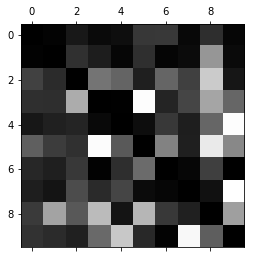

In [37]:
np.fill_diagonal(normalized_conf_matrix,0)
plt.matshow(normalized_conf_matrix, cmap=plt.cm.gray)
plt.show()

Now that diagonal is all 0, which means it's all black, the perfect image of matrix would be if all is black. If there is a row or column that contains many light block, means that the classifier isnt doing such a great job.  

We see in row 8 and 9 there is abundant light squares. This means that a lot of 8 and 9 images are misclassified. The column 8 and 9 are also abundantly light which means that a lot of images are classified as an 8 or 9. We can interpret the quality of classifier roughly from the image of the matrix.  

To improve, we can add more training data to the classifier especially for ones that gets misclassified a lot. We can also preprocess the images first or add new features (algorithm) to classifier to better differentiate figures. Example: number of closed loops, 8 has 2, 6 has 1,...   

We can also analyze individual errors to gain insight on the classifier. 

## <a id="multilabel_classification">Multilabel Classification</a>

We sometimes want classifier to output multiple classes for each instance. Example is if there is a picture consisting of 3 people. It should give label for each person. Say if each classifier has been trained to recognize three faces : Alice, Bob, Charlie. So if there is a picture of Alice and Charlie, it should output (1,0,1). Then the classification output multiple binary labels.  


In [38]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [39]:
knn_clf.predict(X_train[20].reshape(1,-1)) # sample

array([[ True,  True]])

## <a id='multioutput_classification'>Multioutput Classification</a>